In [1]:
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
import tqdm
from collections import defaultdict


# import imageio
from PIL import Image


In [2]:
"""agent class"""

class Agent:
    def __init__(
        self,
        group: int,
        init_position: tuple[int],
        init_fitness: float,
        id=int,
    ):
        self.group = group
        self.position_hist = [init_position]
        self.fitness_hist = [init_fitness]
        self.id = id

    @property
    def position(self):
        return self.position_hist[-1]

    @property
    def fitness(self):
        return self.fitness_hist[-1]

    def add_unchanged_step(self):
        pos, fit = self.position, self.fitness
        self.position_hist.append(pos)
        self.fitness_hist.append(fit)

    def move_position(self, L):
        x, y = self.position

        move_axis = np.random.choice([0, 1])

        if move_axis == 0:
            dx = np.random.choice([-1, 1])
            x = int(np.clip(x + dx, 0, L-1))
        else:
            dy = np.random.choice([-1, 1])
            y = int(np.clip(y + dy, 0, L-1))
        self.position_hist.append((x, y))


In [3]:
def get_time_string():
    return datetime.now().strftime("%Y%m%d_%H%M%S")


class Game:
    def __init__(
        self,
        n_a: int,
        n_b: int,
        grid_size: int = 25,
        eta: float = 10,
        x: float = 0.05,
    ):
        self.grid_size = grid_size
        self.eta = eta
        self.x = x

        self.n_a = n_a
        self.n_b = n_b
        self.n = n_a + n_b

        self.init_fitness = 1000 / self.n

        self.group = np.zeros(self.n, dtype=np.int8)
        self.group[n_a:] = 1  # 0 = A, 1 = B

        self.positions = np.random.randint(0, grid_size, size=(self.n, 2))
        self.fitness = np.full(self.n, self.init_fitness, dtype=np.float64)
        self.fitness_norm = self.fitness.copy()
        self.history = [[] for _ in range(self.n)]

        # Saving path
        self.path = os.path.join("interactions", get_time_string())
        self.path_grid = os.path.join(self.path, "grid")
        os.makedirs(self.path, exist_ok=True)
        os.makedirs(self.path_grid, exist_ok=True)

    def play_game(self, t_max: int, save_every: int | None = None, plot: bool = False):
        for t in tqdm.tqdm(range(t_max)):
            self.play_one_iter()
            if save_every is not None and t % save_every == 0:
                self.plot_current_situation(t, plot=plot)
        self.plot_fitness(t_max, plot=plot)

    def play_one_iter(self):
        self.update_extreme_fitness()
        self.move_all_agents()
        self.update_all_normalized_fitness()
        self.check_and_do_fight()

    def move_all_agents(self):
        moves = np.random.randint(-1, 2, size=(self.n, 2))
        self.positions = np.mod(self.positions + moves, self.grid_size)

        self.grid = defaultdict(list)
        for idx, pos in enumerate(self.positions):
            self.grid[tuple(pos)].append(idx)
        self.populated_cells = list(self.grid.keys())

    def check_and_do_fight(self):
        for pos in self.populated_cells:
            idxs = self.grid[pos]
            if len(idxs) == 1:
                i = idxs[0]
                self.history[i].append(self.fitness[i])
            else:
                g0 = [i for i in idxs if self.group[i] == 0]
                g1 = [i for i in idxs if self.group[i] == 1]
                if g0 and g1:
                    i0 = np.random.choice(g0)
                    i1 = np.random.choice(g1)
                    self.fight(i0, i1)
                    for i in idxs:
                        if i not in (i0, i1):
                            self.history[i].append(self.fitness[i])
                else:
                    for i in idxs:
                        self.history[i].append(self.fitness[i])

    def fight(self, i1, i2):
        if self.group[i1] == 1:
            i1, i2 = i2, i1

        f1, f2 = self.fitness[i1], self.fitness[i2]
        f1_norm, f2_norm = self.fitness_norm[i1], self.fitness_norm[i2]

        p_win = 1 / (1 + np.exp(self.eta * (f2_norm - f1_norm)))
        if np.random.rand() < p_win:
            self.fitness[i1] += self.x * f2
            self.fitness[i2] -= self.x * f2
        else:
            self.fitness[i1] -= self.x * f1
            self.fitness[i2] += self.x * f1

        self.history[i1].append(self.fitness[i1])
        self.history[i2].append(self.fitness[i2])

    def update_extreme_fitness(self):
        self.extreme_min = {
            0: np.min(self.fitness[self.group == 0]),
            1: np.min(self.fitness[self.group == 1])
        }
        self.extreme_max = {
            0: np.max(self.fitness[self.group == 0]),
            1: np.max(self.fitness[self.group == 1])
        }
        
    def update_all_normalized_fitness(self):
        eps = 1e-10
        for g in [0, 1]:
            idxs = np.where(self.group == g)[0]
            f_min, f_max = self.extreme_min[g], self.extreme_max[g]
            self.fitness_norm[idxs] = (self.fitness[idxs] - f_min + eps) / (f_max - f_min + eps)

    def plot_fitness(self, t_max, plot: bool = False):
        for g in [0, 1]:
            plt.figure()
            plt.title(f"Group {g}")
            for i in np.where(self.group == g)[0]:
                if len(self.history[i]) != t_max + 1:
                    continue
                plt.plot(self.history[i])
            plt.grid()
            plt.savefig(os.path.join(self.path, f"fitness_{g}.png"))
            if plot:
                plt.show()
            plt.close()

    def plot_current_situation(self, step: int, plot: bool):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f"Time {step}")
        for g in [0, 1]:
            idxs = np.where(self.group == g)[0]
            pos = self.positions[idxs]
            fit = self.fitness[idxs]
            sc = axes[g].scatter(
                pos[:, 0], pos[:, 1], c=fit, cmap="Blues" if g == 0 else "Greens",
                vmin=np.min(fit), vmax=np.max(fit)
            )
            fig.colorbar(sc, ax=axes[g], label="Fitness")
            axes[g].set_title(f"Group {g}")
            axes[g].grid()
            axes[g].set_xticks(np.arange(self.grid_size + 1))
            axes[g].set_yticks(np.arange(self.grid_size + 1))
            axes[g].set_aspect("equal")
            axes[g].set_xlim((-0.5, self.grid_size + 0.5))
            axes[g].set_ylim((-0.5, self.grid_size + 0.5))

        plt.savefig(os.path.join(self.path_grid, f"{str(step)}.png"), dpi=100)
        if plot:
            plt.show()
        plt.close()


In [4]:
### Params 
n_a = 500
n_b = 50
grid_size = 25
eta = 5
x = 0.05

In [5]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=150000, save_every=None, plot=False)

100%|██████████| 150000/150000 [10:33<00:00, 236.93it/s]


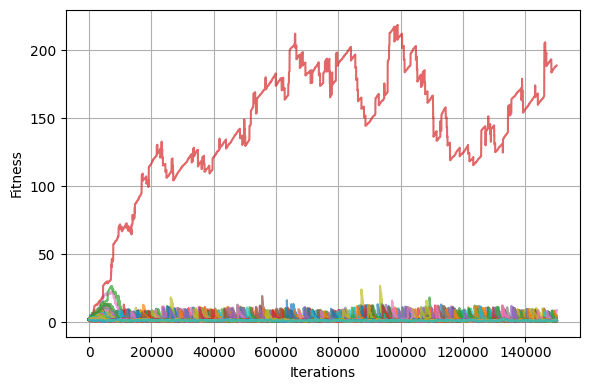

In [6]:
plt.figure(figsize=(6, 4))

group_index = 0
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness A")
plt.grid(True)
plt.tight_layout()
plt.show()

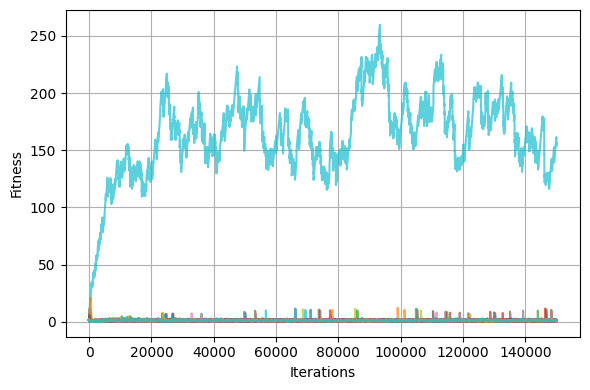

In [7]:
plt.figure(figsize=(6, 4))

group_index = 1
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness B")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
### Params 
n_a = 500
n_b = 50
grid_size = 25
eta = 10
x = 0.05

In [9]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=5000, save_every=None, plot=False)

100%|██████████| 5000/5000 [00:20<00:00, 240.15it/s]


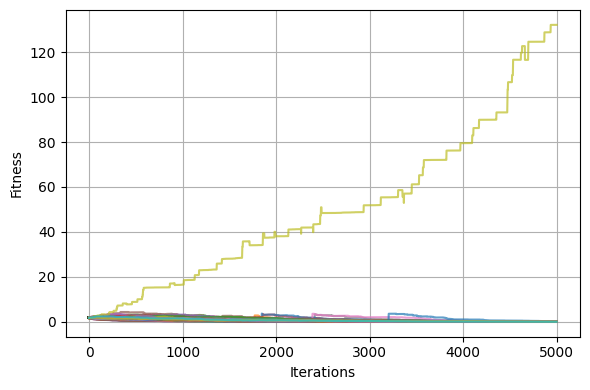

In [10]:
plt.figure(figsize=(6, 4))

group_index = 0
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness A")
plt.grid(True)
plt.tight_layout()
plt.show()

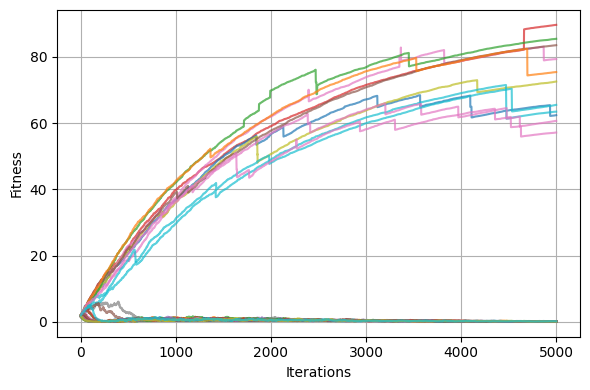

In [11]:
plt.figure(figsize=(6, 4))

group_index = 1
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness B ")
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=150000, save_every=None, plot=False)

100%|██████████| 150000/150000 [10:25<00:00, 239.76it/s]


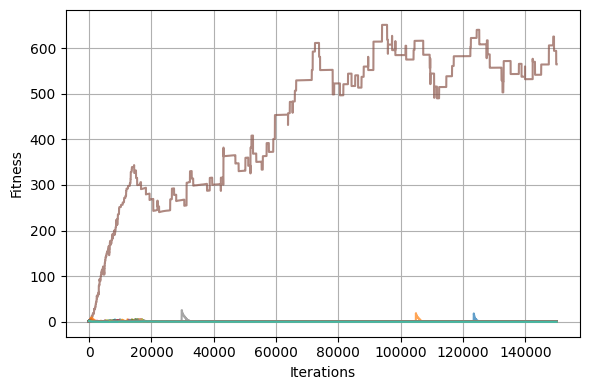

In [13]:
plt.figure(figsize=(6, 4))

group_index = 0
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

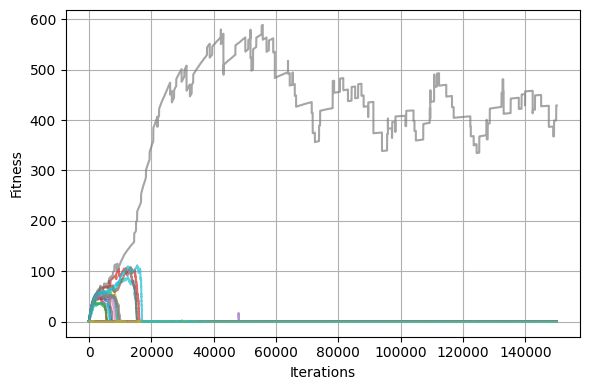

In [14]:
plt.figure(figsize=(6, 4))

group_index = 1
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
### Params 
n_a = 500
n_b = 50
grid_size = 25
eta = 1
x = 0.05

In [16]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=5000, save_every=None, plot=False)

100%|██████████| 5000/5000 [00:23<00:00, 209.23it/s]


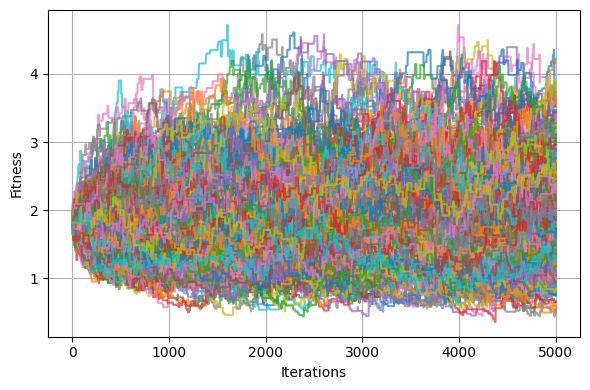

In [17]:
plt.figure(figsize=(6, 4))

group_index = 0
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

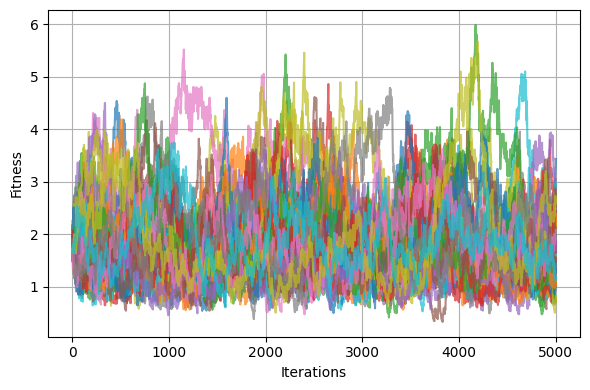

In [18]:
plt.figure(figsize=(6, 4))

group_index = 1
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
### Short term : emergence of a leader (5000 iterations)
game = Game(n_a=n_a, n_b=n_b, grid_size=grid_size, eta=eta, x=x)
game.play_game(t_max=150000, save_every=None, plot=False)

100%|██████████| 150000/150000 [11:34<00:00, 215.91it/s]


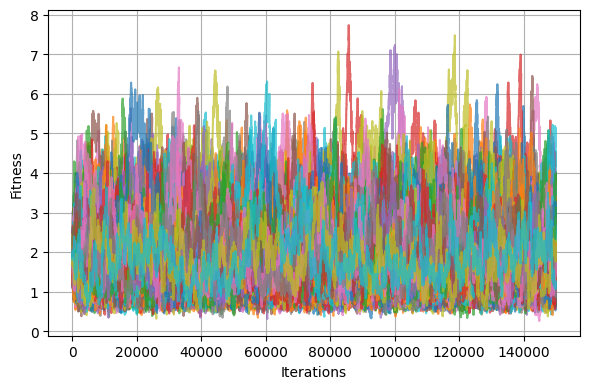

In [20]:
plt.figure(figsize=(6, 4))

group_index = 0
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

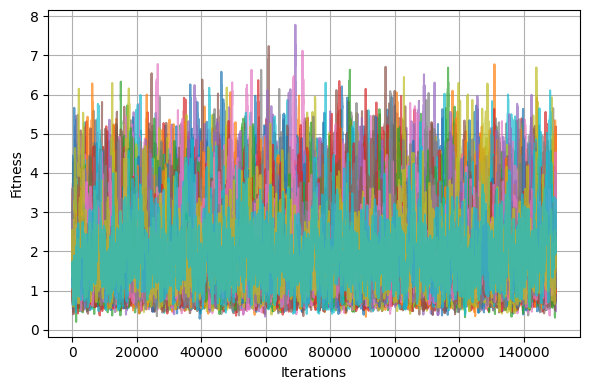

In [21]:
plt.figure(figsize=(6, 4))

group_index = 1
idxs = np.where(game.group == group_index)[0]

for i in idxs:
    fitness_hist = game.history[i]
    plt.plot(fitness_hist, alpha=0.7)

plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()

## **Phase diagram**

In [4]:
### Params 
n_a = 500
n_b = 50
grid_size = 25
eta = 1
x = 0.05

In [ ]:
### Parallelization

In [27]:
def simulate_point(alpha, eta, N_T=550, t_max=40000):
    N_A = int(alpha * N_T)
    N_B = N_T - N_A
    game = Game(n_a=N_A, n_b=N_B, eta=eta, x=0.05)
    game.play_game(t_max=t_max)
    
    fitness_A = game.fitness[game.group == 0]
    fmax = np.max(fitness_A)
    ftot_A = np.sum(fitness_A)
    ftot = np.sum(game.fitness)
    
    return alpha, eta, fmax / ftot_A, ftot_A / ftot


In [28]:
etas = np.linspace(0.1, 14,30)
alphas = np.linspace(0.05, 0.95, 30)
grid = [(a, e) for a in alphas for e in etas]


In [29]:
results = Parallel(n_jobs=-1)(
    delayed(simulate_point)(alpha, eta) for (alpha, eta) in grid
)


python(39496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39499) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39500) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39502) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39503) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
  5%|▌         | 2188/40000 [00:21<07:14, 86.94it/s]/opt/anaconda3/envs/test/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the

In [30]:
heatmap_fmax = np.zeros((len(alphas), len(etas)))
heatmap_ftot = np.zeros((len(alphas), len(etas)))

alpha_to_idx = {round(a, 4): i for i, a in enumerate(alphas)}
eta_to_idx = {round(e, 4): j for j, e in enumerate(etas)}

for alpha, eta, ratio_fmax, ratio_ftot in results:
    i = alpha_to_idx[round(alpha, 4)]
    j = eta_to_idx[round(eta, 4)]
    heatmap_fmax[i, j] = ratio_fmax
    heatmap_ftot[i, j] = ratio_ftot


In [31]:
## Grids
etas = np.linspace(0.1, 14,30)
alphas = np.linspace(0.05, 0.95, 30)


## Results
heatmap_fmax = np.zeros((len(alphas), len(etas)))
heatmap_ftot = np.zeros((len(alphas), len(etas)))

## Mapping
alpha_to_idx = {round(a, 4): i for i, a in enumerate(alphas)}
eta_to_idx = {round(e, 4): j for j, e in enumerate(etas)}

## Fill in
for alpha, eta, ratio_fmax, ratio_ftot in results:
    i = alpha_to_idx[round(alpha, 4)]
    j = eta_to_idx[round(eta, 4)]
    heatmap_fmax[i, j] = ratio_fmax
    heatmap_ftot[i, j] = ratio_ftot


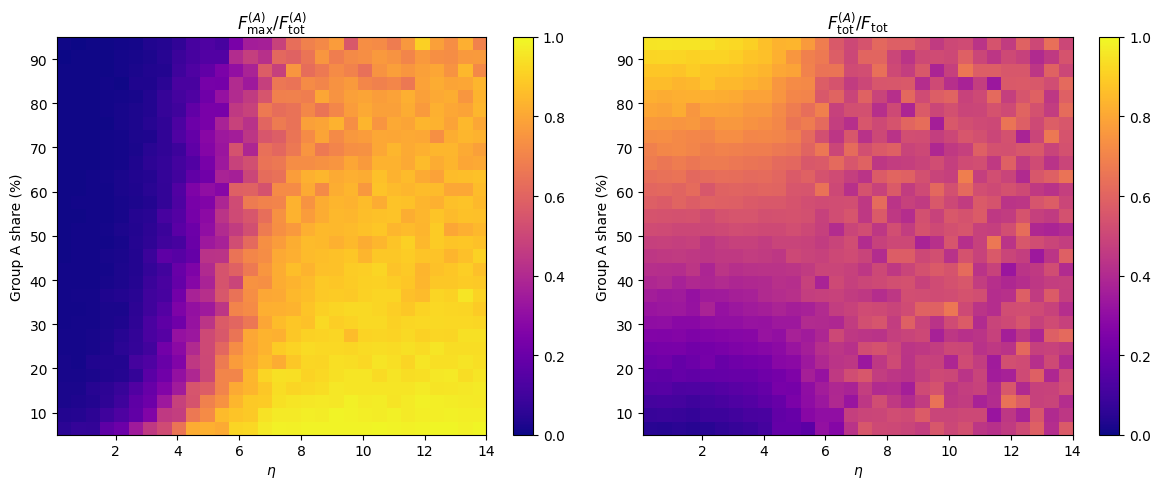

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

## F_max / F_tot^A
im1 = axs[0].imshow(heatmap_fmax, origin='lower', aspect='auto',
                   extent=[etas[0], etas[-1], alphas[0]*100, alphas[-1]*100],
                   cmap='plasma', vmin=0, vmax=1)
axs[0].set_title(r"$F_{\max}^{(A)} / F_{\mathrm{tot}}^{(A)}$")
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel(r"Group A share (%)")
fig.colorbar(im1, ax=axs[0])

## F_tot^A / F_tot
im2 = axs[1].imshow(heatmap_ftot, origin='lower', aspect='auto',
                   extent=[etas[0], etas[-1], alphas[0]*100, alphas[-1]*100],
                   cmap='plasma', vmin=0, vmax=1)
axs[1].set_title(r"$F_{\mathrm{tot}}^{(A)} / F_{\mathrm{tot}}$")
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel(r"Group A share (%)")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.savefig("heatmaps_scaling.png", dpi=300)
plt.show()
